# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# For XGBoost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# For LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# 2. Load & Preprocess Data

In [2]:
# Load your dataset (e.g., train.csv from Walmart)
df = pd.read_csv("train.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date')["Weekly_Sales"].sum().reset_index()
df = df.sort_values('Date')


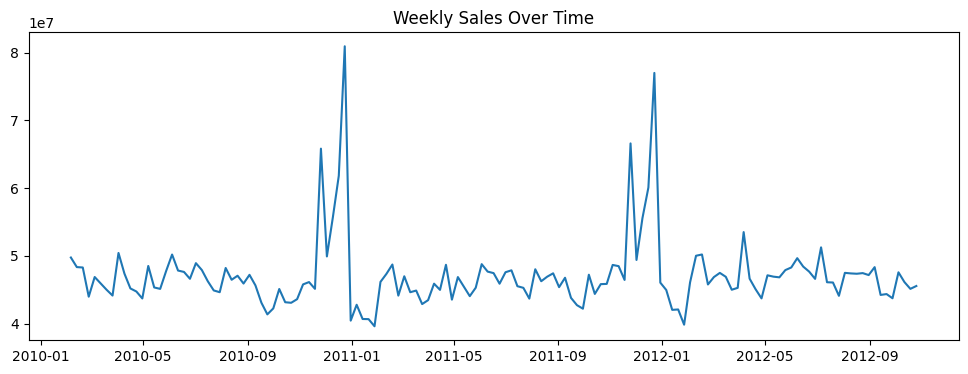

In [3]:
# Plot the data
plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['Weekly_Sales'])
plt.title("Weekly Sales Over Time")
plt.show()


# 3. Feature Engineering for XGBoost

In [4]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['week'] = df['Date'].dt.isocalendar().week

# Lag features
df['lag_1'] = df['Weekly_Sales'].shift(1)
df['lag_2'] = df['Weekly_Sales'].shift(2)
df['rolling_mean_3'] = df['Weekly_Sales'].rolling(3).mean()
df = df.dropna()

# Define X and y for XGBoost
X = df[['year', 'month', 'week', 'lag_1', 'lag_2', 'rolling_mean_3']]
y = df['Weekly_Sales']

# 4. Train XGBoost Model

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model_xgb = XGBRegressor(n_estimators=100)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

In [6]:
# Evaluation
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost MAPE: {mape_xgb:.2%}")

XGBoost RMSE: 1559039.12
XGBoost MAPE: 2.70%


# 5. Prepare Data for LSTM

In [7]:
series = df['Weekly_Sales'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(series)

# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 4
X_lstm, y_lstm = create_sequences(scaled_series, window_size)

# Train-test split
split = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

# 6. Build & Train LSTM

In [8]:
model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=20, verbose=1)

# Prediction
y_pred_lstm = model_lstm.predict(X_test_lstm)
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_test_lstm_inv = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Evaluation
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_inv, y_pred_lstm_inv))
mape_lstm = mean_absolute_percentage_error(y_test_lstm_inv, y_pred_lstm_inv)
print(f"LSTM RMSE: {rmse_lstm:.2f}")
print(f"LSTM MAPE: {mape_lstm:.2%}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 357ms/step - loss: 0.0432
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0445 
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0333 
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0282 
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0250 
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0219 
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0195
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0231 
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0170 
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0205 
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0218 
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0168 
Epoch 13/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0281 
Epoch 14/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0150 
Epoch 15/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0220 
Epoch 16/20
4/4 ━━━━━━━━━━━━━━━━━

# 7. Visualize Forecasts

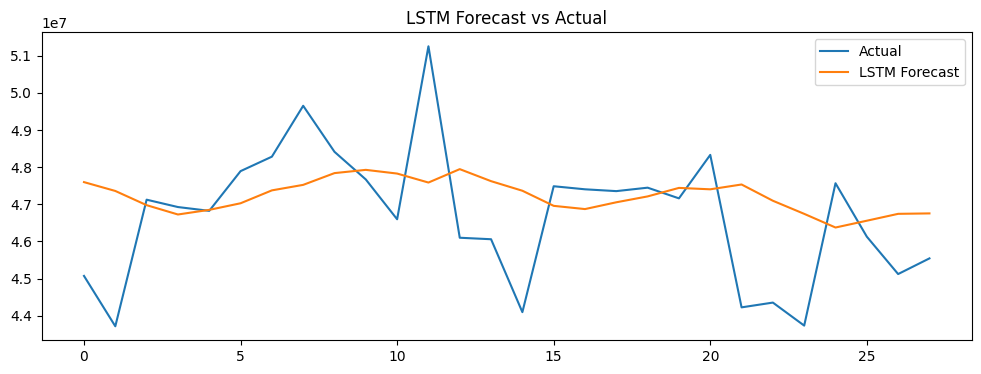

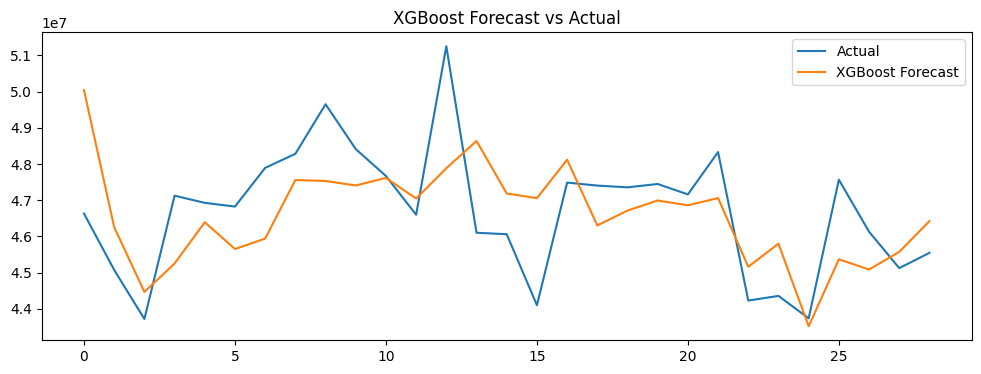

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(y_test_lstm_inv, label='Actual')
plt.plot(y_pred_lstm_inv, label='LSTM Forecast')
plt.title("LSTM Forecast vs Actual")
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_xgb, label='XGBoost Forecast')
plt.title("XGBoost Forecast vs Actual")
plt.legend()
plt.show()